# **<font color = 'hotpink'>Leveraging Transfer Learning Techniques with ResNet18 for Enhanced MNIST Digit Recognition**


**This project investigates the application of transfer learning techniques with the ResNet18 architecture to enhance handwritten digit recognition, focusing on the well-known MNIST dataset.**

<font color='hotpink'>Importing necessary libraries

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

<font color='hotpink'> Constants and hyperparameters

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 10

NUM_FEATURES = 28*28
NUM_CLASSES = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = True

<font color='hotpink'>Loading pre-trained ResNet18 model and modifying the fully connected layer


In [3]:
resnet18 = models.resnet18(pretrained=True)
#resnet18.fc = nn.Linear(resnet18.fc.in_features, NUM_CLASSES)
for param in resnet18.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [4]:
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)

<font color='hotpink'> Data preprocessing and transformations

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 340706323.50it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 99782284.86it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 104618210.10it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23204054.53it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



<font color='hotpink'> Creating data loaders

In [7]:
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

<font color='hotpink'> Defining loss function, optimizer, and learning rate scheduler

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

<font color='hotpink'>Setting up device and model for training and training loop

In [9]:
print(DEVICE)
resnet18.to(DEVICE)
resnet18.train()

epoch_losses=[]

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for index, (inputs, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}")

cuda


Epoch 1/10: 100%|██████████| 938/938 [03:04<00:00,  5.07it/s]


Epoch 1/10, Loss: 0.3426


Epoch 2/10: 100%|██████████| 938/938 [02:55<00:00,  5.35it/s]


Epoch 2/10, Loss: 0.1978


Epoch 3/10: 100%|██████████| 938/938 [02:54<00:00,  5.37it/s]


Epoch 3/10, Loss: 0.1738


Epoch 4/10: 100%|██████████| 938/938 [02:53<00:00,  5.40it/s]


Epoch 4/10, Loss: 0.1188


Epoch 5/10: 100%|██████████| 938/938 [03:28<00:00,  4.49it/s]


Epoch 5/10, Loss: 0.1090


Epoch 6/10: 100%|██████████| 938/938 [03:16<00:00,  4.78it/s]


Epoch 6/10, Loss: 0.1042


Epoch 7/10: 100%|██████████| 938/938 [02:46<00:00,  5.65it/s]


Epoch 7/10, Loss: 0.0985


Epoch 8/10: 100%|██████████| 938/938 [02:45<00:00,  5.67it/s]


Epoch 8/10, Loss: 0.0966


Epoch 9/10: 100%|██████████| 938/938 [02:47<00:00,  5.61it/s]


Epoch 9/10, Loss: 0.0966


Epoch 10/10: 100%|██████████| 938/938 [02:46<00:00,  5.64it/s]

Epoch 10/10, Loss: 0.0958


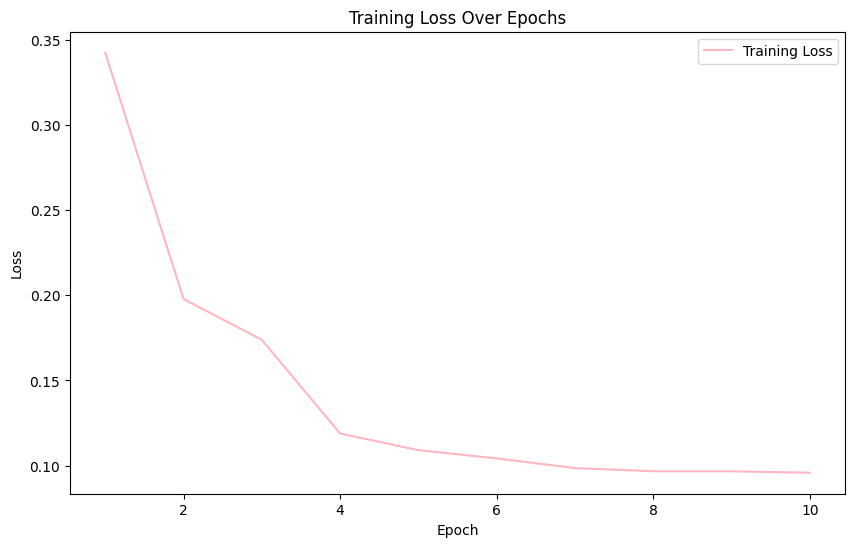

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), epoch_losses, label='Training Loss', color='lightpink')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<font color='hotpink'> Evaluation on the test set

In [11]:
resnet18.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs, 1)

        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on the test set: {accuracy:.4f}")
# accuracy = correct / total
# print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9743


<Figure size 1000x800 with 0 Axes>

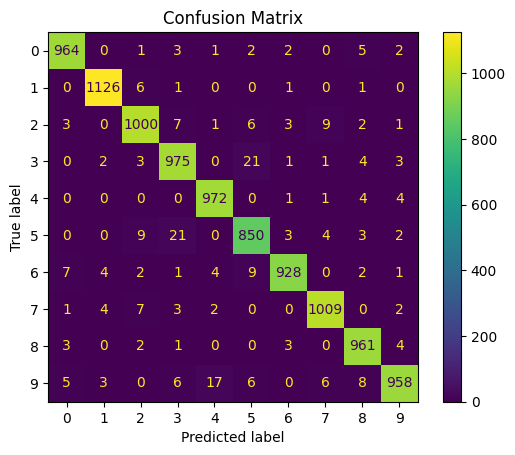

In [12]:
cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(cm, display_labels=range(NUM_CLASSES)).plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

<font color='hotpink'> Visualizing some predictions

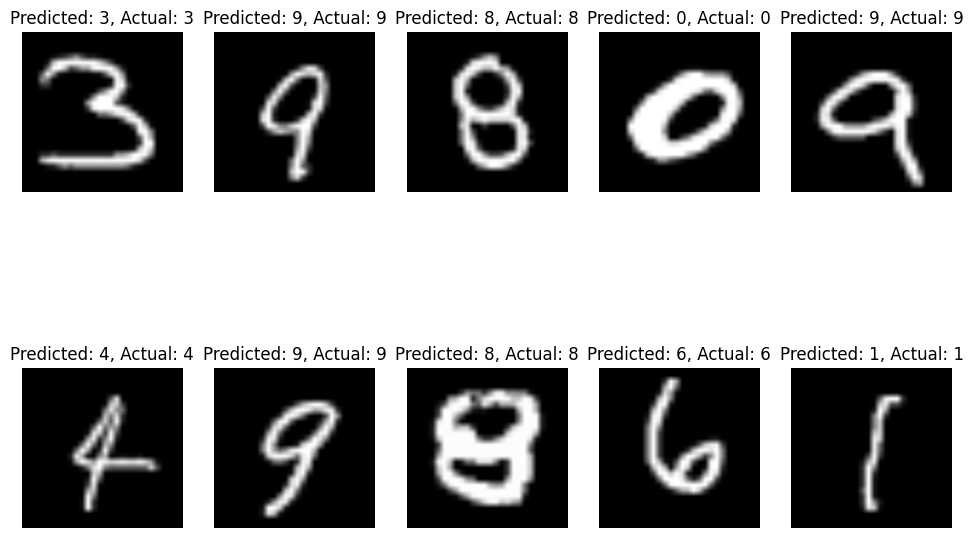

In [13]:
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = inputs[i].cpu().numpy().squeeze()

    if len(image.shape) == 3:
        image = image[0]

    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted: {predicted[i]}, Actual: {labels[i]}')
    plt.axis('off')
plt.show()